```{contents}
```
## Edge

An **Edge** in LangGraph is a **directed transition rule** that determines **how execution flows from one node to another** based on the current state.
Edges transform a static set of nodes into a **dynamic, executable computation graph**.

---

### **1. Conceptual Role of an Edge**

An edge answers the question:

> **“What should execute next?”**

Edges encode **control flow logic**, similar to:

* program counters in CPUs,
* transitions in finite state machines,
* branches and loops in programs.

```
Node A  ────edge──▶  Node B
```

---

### **2. Why Edges Matter**

Without edges, nodes are isolated computations.
Edges provide:

| Capability  | Purpose                 |
| ----------- | ----------------------- |
| Sequencing  | Enforce execution order |
| Branching   | Conditional decisions   |
| Iteration   | Cyclic behavior         |
| Parallelism | Concurrent execution    |
| Termination | Stopping conditions     |

---

### **3. Core Edge Types in LangGraph**

| Edge Type            | Description                              |
| -------------------- | ---------------------------------------- |
| **Static Edge**      | Always transitions to the same next node |
| **Conditional Edge** | Chooses next node using state            |
| **Dynamic Edge**     | Computed at runtime                      |
| **Cyclic Edge**      | Creates loops                            |
| **Terminal Edge**    | Ends execution (`END`)                   |

---

### **4. Static Edges**

Used for **deterministic sequencing**.

```python
builder.add_edge("parse", "analyze")
```

```
parse → analyze
```

---

### **5. Conditional Edges**

Used for **branching decisions**.

```python
def route(state):
    return "tool" if state["need_tool"] else "final"

builder.add_conditional_edges(
    "decide",
    route,
    {
        "tool": "tool_node",
        "final": "answer_node"
    }
)
```

```
decide ──(need_tool?)──▶ tool_node
       └──────────────▶ answer_node
```

---

### **6. Dynamic & Cyclic Edges**

Cyclic edges enable **iteration and feedback**.

```python
builder.add_edge("observe", "reason")  # loop
```

This enables patterns such as **ReAct**, **self-reflection**, and **planning loops**.

---

### **7. Terminal Edges**

LangGraph provides a special terminal symbol:

```python
from langgraph.graph import END
```

```python
builder.add_edge("final", END)
```

This marks **successful termination**.

---

### **8. Full Minimal Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    count: int

def increment(state):
    return {"count": state["count"] + 1}

def decide(state):
    return END if state["count"] >= 3 else "increment"

builder = StateGraph(State)
builder.add_node("increment", increment)
builder.add_node("decide", decide)

builder.set_entry_point("increment")
builder.add_edge("increment", "decide")

builder.add_conditional_edges(
    "decide",
    lambda s: END if s["count"] >= 3 else "increment",
    {"increment": "increment", END: END}
)

graph = builder.compile()
print(graph.invoke({"count": 0}))
```

---

### **9. Edge Design Patterns**

| Pattern  | Purpose               |
| -------- | --------------------- |
| Pipeline | Linear processing     |
| Router   | Conditional branching |
| Loop     | Iteration             |
| Join     | Merge parallel paths  |
| Gate     | Human approval        |
| Failover | Error handling        |

---

### **10. Production Considerations**

| Concern        | Solution           |
| -------------- | ------------------ |
| Infinite loops | `recursion_limit`  |
| Failure        | Retry edges        |
| Timeout        | Time-based exit    |
| Observability  | Edge-level tracing |
| Safety         | Human gate edges   |

```python
graph.invoke(input, config={"recursion_limit": 20})
```

---

### **11. Mental Model**

An **Edge** is the **decision logic of the graph**.
Nodes perform work.
Edges decide **control flow**.

> **Nodes compute.
> Edges govern execution.**


### Demonstration

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

# -------------------------
# 1. Define State Schema
# -------------------------
class State(TypedDict):
    count: int

# -------------------------
# 2. Define Nodes
# -------------------------
def increment(state: State):
    return {"count": state["count"] + 1}

def decide(state: State):
    # Node must return only state updates
    return {}

# -------------------------
# 3. Routing Logic (Edges decide flow)
# -------------------------
def router(state: State):
    if state["count"] >= 3:
        return END
    return "increment"

# -------------------------
# 4. Build Graph
# -------------------------
builder = StateGraph(State)

builder.add_node("increment", increment)
builder.add_node("decide", decide)

builder.set_entry_point("increment")

# Static edge
builder.add_edge("increment", "decide")

# Conditional + cyclic + terminal edges
builder.add_conditional_edges(
    "decide",
    router,
    {"increment": "increment", END: END}
)

graph = builder.compile()

# -------------------------
# 5. Run Graph
# -------------------------
result = graph.invoke({"count": 0})
print(result)


{'count': 3}


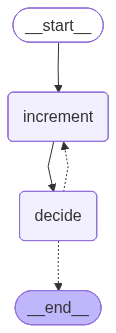

In [4]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())